# Projet Simulation Numérique ENSEEIHT 2022-2023
### Groupe: B1
### Nom: Belmakhfi
### Prénom: Nihal
### Commentaire: 

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 10/3/23 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Enseignement**

Voici les informations concernant les séances (date, heure):

10/3/23 14.00-16.00 C/TD Groupes B1 et B2 (B306)

14/3/23 14.00-18.00 TP Groupe B1 (C306)

17/3/23 08.00-12.00 TP Groupe B2 (C203)

24/3/23 14.00-16.00 TD Séance de réponse à vos questions (B306)

**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  19 avril 2023 à midi. 

**Contact**: xavier.vasseur@irit.fr

Merci d'indiquer [PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [1]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [2]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdfs]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    ratio: current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n)
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [3]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
    
    
    #
    #ALGORITHME
    #
    #function [Js, Z] = ID col(A, k)
    #[Q, S, J] = qr(A, 0);
    #T = (S(1 : k, 1 : k))^(-1) S(1 : k, (k + 1) : n);
    #Z = zeros(k, n)
    #Z(:, J) = [Ik T];
    #Js = J(1 : k);
    
    
 
    # Perform the economic decomposition of A with column pivoting 
    Q,S,J = qr(A, mode='economic', pivoting=True)
    R11, R12 = S[:k,:k], S[:k,k:]
    
    # Deduce the T=R11^{-1}R12 block 
    T = solve_triangular(R11, R12)
    
    # Deduce J and Z 
    I = np.eye(k)
    Z[:,J] = np.concatenate((I, T), axis=1) 
    J = J[:k]
    
    return J,Z



def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    #
    #ALGORITHME
    #
    #function [Is, X] = ID row(A, k)
    #[Q, S, J] = qr(A∗, 0);
    #T = (S(1 : k, 1 : k))−1S(1 : k, (k + 1) : m);
    #X = zeros(m, k)
    #X(J, :) = [Ik T]∗;
    #Is = J(1 : k);

    
    # Perform the economic decomposition of A^T with column pivoting 
    Q,S,I = qr(np.transpose(A), mode='economic', pivoting=True)
    R11, R12 = S[:k,:k], S[:k,k:]
          
    # Deduce the corresponding T block 
    T = solve_triangular(R11, R12)
    
    # Deduce I and X 
    Ik = np.eye(k)
    X[I,:] = np.transpose (np.concatenate((Ik, T),axis=1))
    I= I[:k]

    return I,X



def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
     
    #
    #ALGORITHME
    #
    #function [Is, Js, X, Z] = ID double(A, k)
    #[Js, Z] = ID col(A, k);
    #[Is, X] = ID row(A(:, Js), k);
    
    
    # Apply the column ID to A
    J,Z = column_ID(A,k)
   
    # Apply the row ID to A[:,J]
    I,X = row_ID(A[:,J],k)
    
    return I,J,X,Z



def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    # Apply the double sided interpolation algorithm 
    I,J,X,Z = double_sided_ID(A,k)
        
    # Deduce the C and R matrices of the CUR formulation 
    C = A[:,J]
    R = A[I,:]
        
    # Solve U R = Z in a least-squares sense
    pseudoInvR = np.linalg.pinv(R)
    U = Z@pseudoInvR   

    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [4]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G    = np.random.randn(n,k+p)
    Y    = A@G
    
    #
    #ALGORITHME
    #
    #for j = 1 : q
    # Y′ = A∗Y;
    # Y = AY′;
    #end for
   

    for j in range(q):
        W = np.transpose(A)@Y
        Y = A@W
    
    # Apply the row ID algorithm to Y
    I,X = row_ID(Y,k)

    return I,X


   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
    Y    = G@A
    
     #
    #ALGORITHME
    #
    #for j = 1 : q
    # Z = YA∗;
    # Y = ZA;
    #end for

    for j in range(q):
        Z = Y@np.transpose(A)
        Y = Z@A 
        
    # Apply the column ID algorithm to Y 
    J, Z = column_ID(Y,k)
    
    # Apply the row ID algorithm to A[:,J]
    I,X = row_ID(A[:,J],k)
        
    # Deduce the CUR matrices (C, R and then U)
    C = A[:,J]
    R = A[I,:]
    pseudoInvR = np.linalg.pinv(R)
    U = Z@pseudoInvR   

    return I,J,C,U,R



## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

### Sydney

(396, 563)


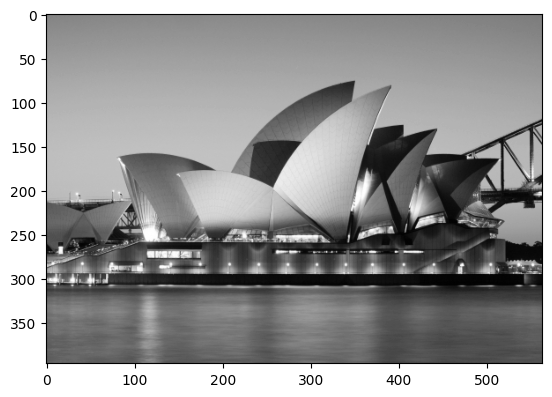

In [5]:
#
# Lecture de l'image 
#
#
imgc = Image.open("Sydney_Opera_House.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.03818154335021973
Estimated upper bound of the epsilon-rank:  96  for relative threshold:  0.05
Frobenius norm ratio:  0.04188407245078461  reached in  6 iterations
Time spent in the CUR algorithm 0.09430670738220215
Time spent in the randomized CUR algorithm 0.07446765899658203
Time spent in the double sided ID algorithm 0.08713078498840332


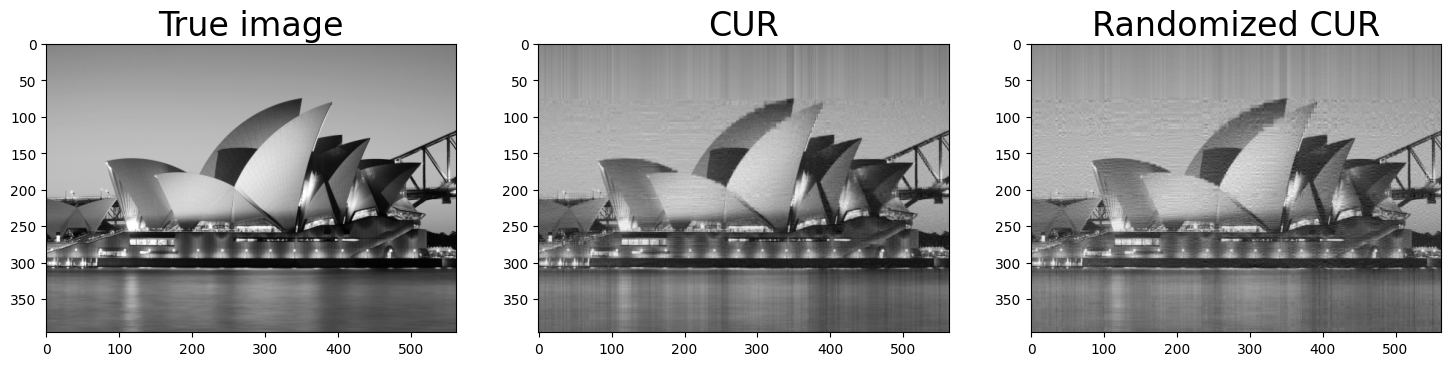

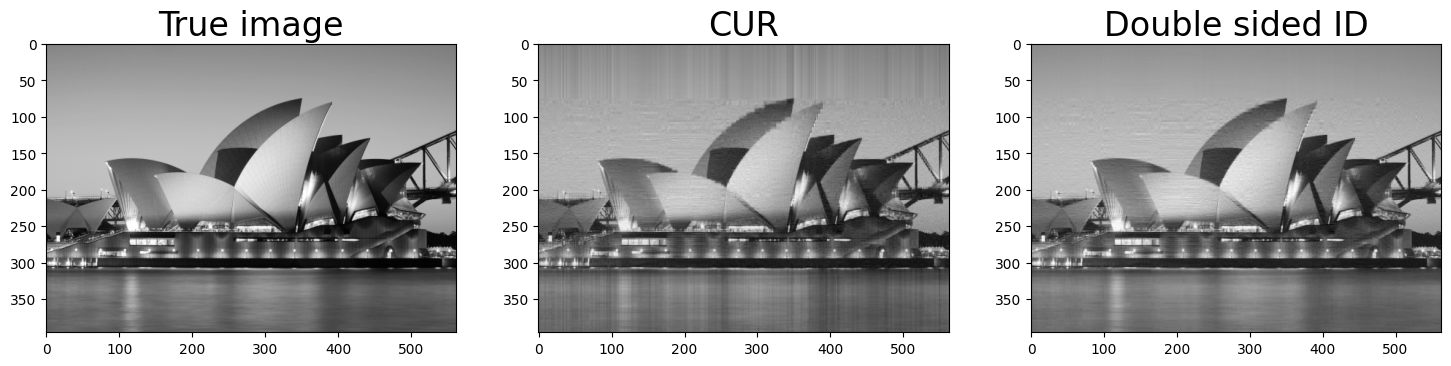

In [6]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#

#ϵ=0.5, ϵ=0.1 et ϵ=0.05
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Tokyo

(1008, 1212)


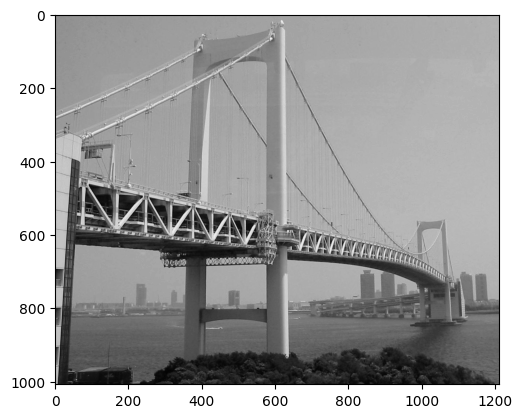

In [7]:
#
# Lecture de l'image 
#
#
#imgc = Image.open("Sydney_Opera_House.jpg")
imgc = Image.open("Tokyo_Rainbow_Bridge.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Tokyo  = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.516399621963501
Estimated upper bound of the epsilon-rank:  272  for relative threshold:  0.05
Frobenius norm ratio:  0.04699732429811681  reached in  17 iterations
Time spent in the CUR algorithm 1.0170717239379883
Time spent in the randomized CUR algorithm 0.7266085147857666
Time spent in the double sided ID algorithm 0.5080051422119141


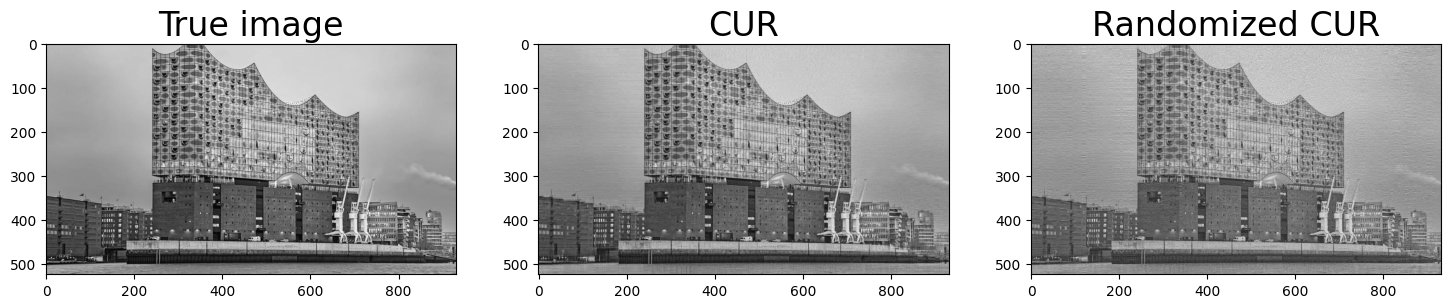

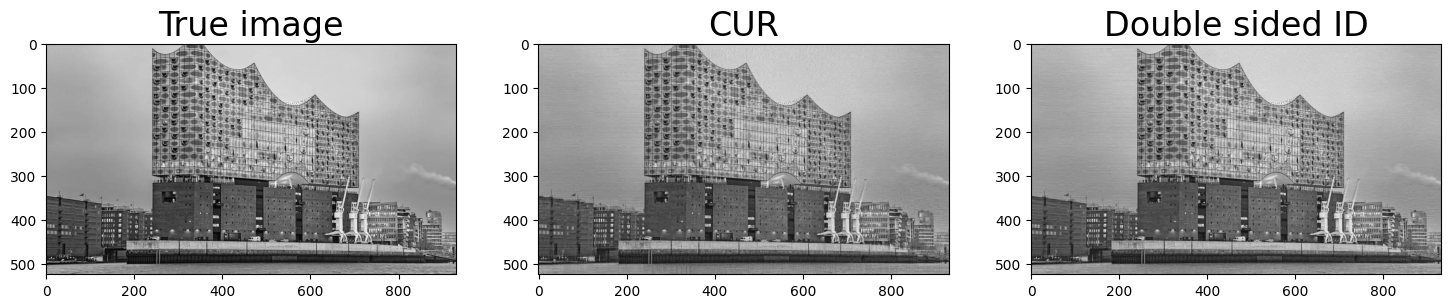

In [17]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#

#ϵ=0.5, ϵ=0.1 et ϵ=0.05
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Tokyo = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_T          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_T,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Hamburg

(524, 932)


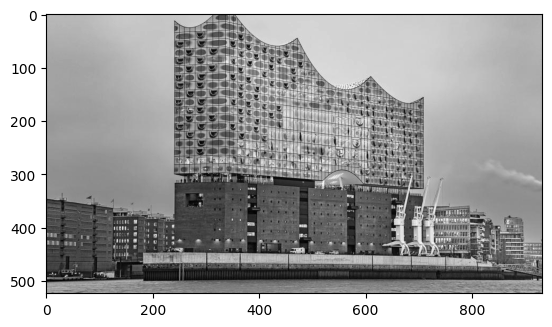

In [15]:
#
# Lecture de l'image [couleur] 
#
#
imgc = Image.open("Hamburg_Elbphilarmonie.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
M_Hamburg = M[:]

print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.06075286865234375
Estimated upper bound of the epsilon-rank:  128  for relative threshold:  0.1
Frobenius norm ratio:  0.09431145234711427  reached in  8 iterations
Time spent in the CUR algorithm 0.18287253379821777
(128, 932)
Time spent in the randomized CUR algorithm 0.1364731788635254
(128, 932)
Time spent in the double sided ID algorithm 0.16815757751464844
(128, 932)


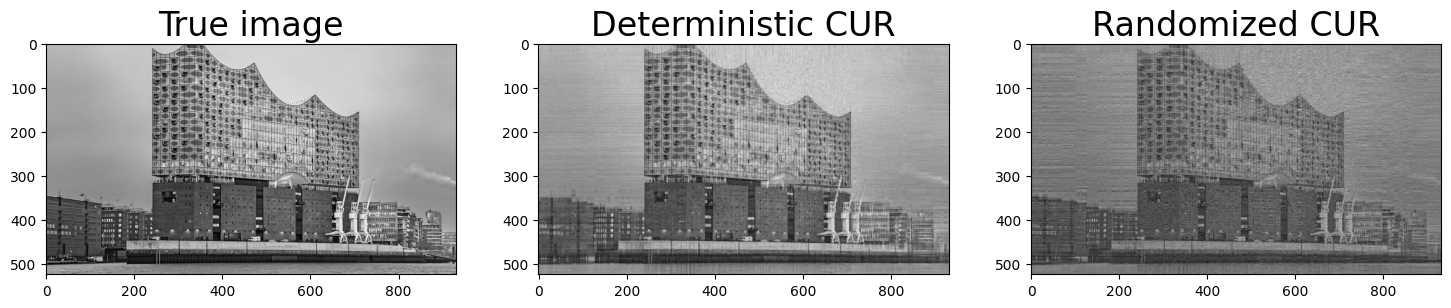

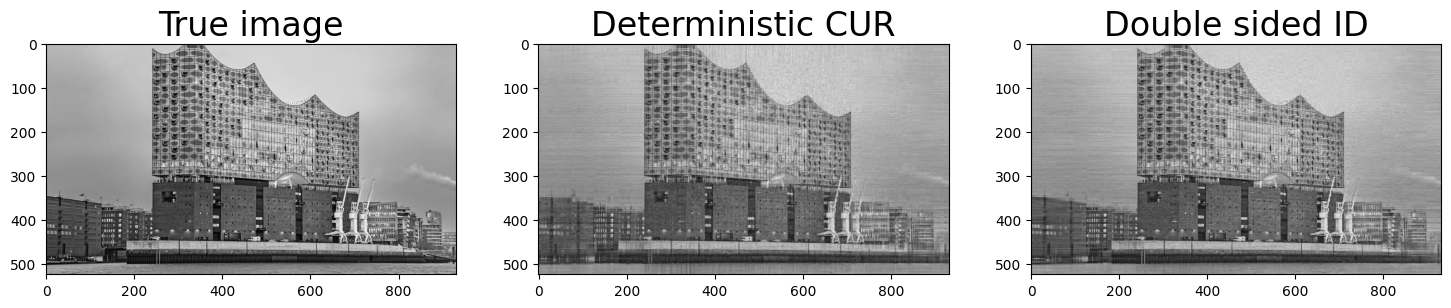

In [16]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Hamburg = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
print(np.shape(R))
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
print(np.shape(R))
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID_H    = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
print(np.shape(Z))
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_H,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Question:**
* B.1 Prenez trois valeurs pour $\epsilon$ (par exemple $\epsilon=0.5$, $\epsilon=0.1$ et $\epsilon=0.05$) et analysez la qualité de l'approximation pour les images considérées. Qu'observez-vous ? 

**Réponse**:
* J'ai constaté que plus la valeur d'epsilon est faible, meilleure est la qualité de l'approximation avec moins de perte de détails. Cependant, cela nécessite un rang approximatif plus élevé de la matrice.

* Lorsque la valeur d'epsilon est de 0.5, l'approximation obtenue est assez grossière, avec une perte importante de détails. Cependant, l'algorithme s'exécute relativement rapidement.

* Lorsque la valeur d'epsilon est de 0.1, l'approximation obtenue est de meilleure qualité avec moins de perte de détails. Cependant, l'algorithme prend plus de temps pour s'exécuter et nécessite.

* Lorsque la valeur d'epsilon est de 0.05, l'approximation obtenue est de très bonne qualité avec une perte minimale de détails. Cependant, l'algorithme prend encore plus de temps pour s'exécuter.

**Question:**
* B.2 Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

**Réponse**:
* Effectivement, j'observe les différences de qualité de reconstruction entre les algorithmes pour une précision identique. 

* En comparant la méthode CUR et la méthode Randomized CUR, on constate que la méthode Randomized CUR renvoie une image avec moins de contraste pour une taille d'image assez grande. Toutefois, pour les les images de tailles plus petites, les deux méthodes renvoient des résultats similaires. De plus, la méthode Randomized CUR est plus rapide pour les images de grande taille, mais elle perd en qualité lors de la reconstruction pour un nombre q élevé. 

* En comparant la méthode CUR et la méthode Double sided ID, on constate que cette dernière renvoie une image presque identique à l'image d'origine mais avec des contrastes moins marqués. De plus, elle est légèrement plus rapide que la méthode CUR pour toutes les tailles d'image. Cependant, la méthode CUR peut perdre en qualité si la valeur de epsilon est augmentée, avec des dégradés de couleurs moins nets et des traits plus nombreux et plus gros sur l'image reconstruite.


## Partie C.

En vous basant notamment sur les notes de cours, le chapitre 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe CUR-ID. 

**Réponse**:
* Avantages: La décomposition déterministe ID offre l'avantage de réduire la taille des matrices, cela permet un stockage moins important en mémoire par rapport aux méthodes de factorisation QR ou SVD. Elle offre également une analyse efficace des données grâce aux indices des colonnes ou des lignes de couverement, en conservant le sens physique des problèmes, notamment dans le cadre de la discrétisation d'EDP ou d'équations intégrales. Par ailleurs, si A est une matrice creuse ou définie positive, les propriétés de la matrice C obtenue après la décomposition restent les mêmes que celles de A.

* Inconvenients: Il est important de noter que cette méthode ne fonctionne bien que si la matrice A est effectivement de rang k. Si tel n'est pas le cas, la décomposition ID avec un rang k donné conduit à une approximation qui présente une erreur plus importante que l'erreur théorique prévue.

* C.2 Expliquer comment paralléliser l'algorithme aléatoire CUR-ID.

**Réponse**:
* le processus de parallélisation de l'algorithme aléatoire CUR-ID consiste à diviser la matrice en blocs, puis à appliquer chaque étape de l'algorithme sur chaque bloc en parallèle. De cette façon, il est possible de réduire considérablement le temps de calcul nécessaire pour exécuter l'algorithme sur des matrices de grande taille. On peut faire cela en suivant les étapes suivantes:
   * Sous-échantillonnage aléatoire de la matrice : La première étape consiste à sélectionner un sous-ensemble aléatoire de colonnes et de lignes de la matrice. Cette étape peut être parallélisée en divisant la matrice en blocs, puis en exécutant le sous-échantillonnage sur chaque bloc en parallèle.

   * Factorisation QR des sous-matrices : La deuxième étape consiste à appliquer une factorisation QR aux sous-matrices obtenues à l'étape précédente. Cette étape peut être parallélisée en appliquant la factorisation QR sur chaque bloc en parallèle.

   * Sélection des colonnes et des lignes : La troisième étape consiste à sélectionner les colonnes et les lignes correspondantes pour construire la matrice C. Cette étape peut également être parallélisée en utilisant plusieurs processus pour sélectionner les colonnes et les lignes à partir de chaque bloc.

   * Construction de la matrice C : Enfin, la matrice C peut être construite en multipliant les colonnes et les lignes sélectionnées. Cette étape peut être parallélisée en multipliant chaque sous-matrice de colonnes et de lignes sélectionnées en parallèle.


## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1) pour obtenir une approximation d'une image donnée en norme de Frobenius. Une attention sera donnée à l'implantation proposée et au temps de restitution obtenu.  Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy.

In [20]:
def nmf(M,erank,epsilon,iteration_max):
    """
    Non-negative matrix factorization for matrix M.
    Input: 
    M:             matrix to be analysed [array type] (of shape (m,n))
    erank:         estimated rank (upper bound of epsilon-rank(M))
    epsilon:       relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    iteration_max: maximal number of iterations [int]
    
    Output:
    X,Y: matrices with positive entries such that $ \|M - X Y \|_F \le \epsilon \|M \|_F$
    iteration: effective number of iterations
    """
    m     = np.shape(M)[0] # nombre de lignes de la matrice M
    n     = np.shape(M)[1] # nombre de colonnes de la matrice M
    
    # Specify two possible first iterates for X and Y
    X = np.random.rand(m,erank) 
    Y = np.random.rand(erank,n)

    # Set variables
    norm_A_Fro    = norm(M,'fro')
    iteration     = 0
    
    # Algorithm 
    while norm(M-X@Y,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        #
        # TO DO
        #
    
        #Nouvelle valeur de Y
        Y =  np.multiply(Y, np.divide(np.transpose(X)@M , np.transpose(X)@(X@Y)))
        #Nouvelle valeur de X 
        X = np.multiply(X, np.divide(M@(np.transpose(Y)) , X@(Y@(np.transpose(Y)))))
        
        iteration += 1
        
        #
        # END TO DO
        #
        if iteration%25 == 0:
            print(iteration,norm(M-X@Y,'fro')/norm_A_Fro)

    return X,Y,iteration

25 0.228334213807735
50 0.1833148226671965
75 0.1579817024998197
100 0.1403857027445225
125 0.1287791572579269
150 0.12081075756982444
175 0.11504915973009099
200 0.11067058979805025
225 0.10721281226924376
250 0.10441050474542042
275 0.10209138784688775
300 0.10013885506105404
325 0.0984725536039448
350 0.09703397230879365
375 0.09577910522093
400 0.09467448827082393
425 0.09369509007084272
450 0.09282096677138375
475 0.09203590569464898
500 0.09132752287913963
525 0.09068595617622222
550 0.09010288447854252
575 0.08957119657598049
600 0.08908476632059881
625 0.08863825378269032
650 0.08822699001209001
675 0.08784688075040645
700 0.08749429860595143
725 0.0871660889949693
750 0.08685958522278515
775 0.08657252730386789
800 0.08630306634268063
825 0.08604960666272744
850 0.0858107374827255
875 0.08558522627086784
900 0.08537192188564285
925 0.08516973995064778
950 0.08497772226543758
975 0.08479509912523345
1000 0.0846212331183121
1025 0.08445550817907391
1050 0.084297343910014
1075 0.

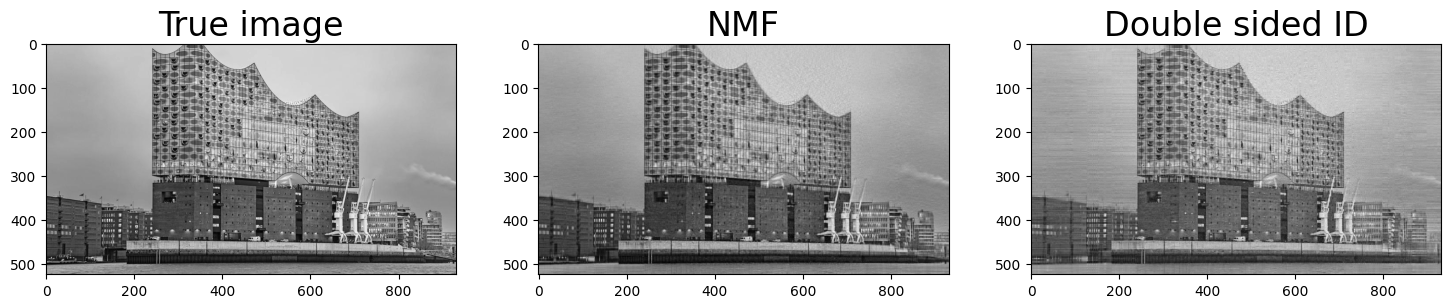

In [21]:
#
# Specify one of the target images here
#
erank = erank_Hamburg
M     = M_Hamburg[:]
JID   = JID_H[:]
#
# NMF 
#
iteration_max = 3500
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.20471512802470643
50 0.1320615998906395
75 0.1029019786778464
100 0.08766136387774552
125 0.07796998011524835
150 0.07115476209285053
175 0.06612672187235671
200 0.06229490687995874
225 0.059289239283306046
250 0.05686927624823473
275 0.054876579507950884
300 0.05320366318595927
325 0.05177556944083804
350 0.050538741371775844
Time spent in the non-negative matrix factorization (NMF) 3.728909969329834
Norm ratio:  0.04995779871298035  reached in  363 iterations


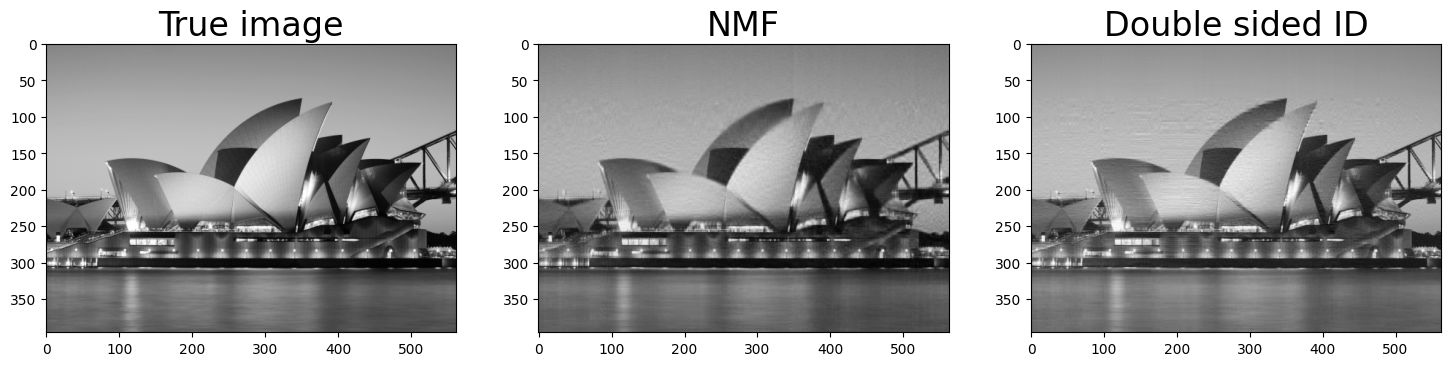

In [22]:
#
# Specify one of the target images here
#
erank = erank_Sydney
M     = M_Sydney[:]
JID   = JID_S[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

In [ ]:
#
# Specify one of the target images here
#
erank = erank_Tokyo
M     = M_Tokyo[:]
JID   = JID_T[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Questions:

* D.1 Pour $\epsilon=0.05$, indiquer pour chacune des images le temps de restitution et le nombre d'itérations. Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite.

**Réponse**:

* Pour les trois images (Hambourg, Sydney et Tokyo) avec une valeur de tolérance ϵ = 0.05, la méthode NMF a convergé en un nombre raisonnable d'itérations. Les temps de restitution étaient de l'ordre de quelques secondes, ce qui est rapide. En termes de qualité de reconstruction, les images NMF ont une ressemblance satisfaisante avec les images originales, avec des différences subtiles. Cela peut être vu dans les graphiques où l'image reconstruite à partir de la NMF est comparée à l'image originale.

* En général, la vitesse de convergence de la méthode est rapide et la qualité de l'image reconstruite est très satisfaisante. Cela est dû en partie à la faible valeur de ϵ choisie, qui permet à l'algorithme de converger rapidement tout en maintenant une précision élevée. Cependant, il convient de noter que la qualité de l'image reconstruite dépend également de la qualité de la double identité utilisée pour l'initialisation de la méthode.


* D.2 A chaque fois, nous avons considéré une image exacte dans chacun des algorithmes pour en déduire une approximation de rang faible. Comment obtenir une approximation de rang faible si l'on dispose uniquement d'une image de qualité médiocre comme image initiale ? Proposez un algorithme. 

**Réponse**:

* Parmi les approches pour obtenir une approximation de rang faible à partir d'une image de qualité médiocre, on trouve
   * Algorithme itératif d'approximation de rang faible (IRLS) : cet algorithme est basé sur l'idée de mettre à jour l'approximation de rang faible de manière itérative. À chaque itération, on calcule la décomposition en valeurs singulières de l'approximation courante, on tronque les valeurs singulières pour obtenir une approximation de rang faible, puis on utilise cette approximation pour mettre à jour l'approximation courante. L'algorithme continue ainsi jusqu'à atteindre une convergence satisfaisante. L'IRLS peut être utilisé avec différentes méthodes pour le troncage des valeurs singulières, comme la méthode de seuillage dur ou la méthode de seuillage doux.
   * Optimisation non convexe de l'approximation de rang faible (NCR) : cet algorithme est basé sur l'optimisation d'une fonction objectif non convexe qui mesure la qualité de l'approximation de rang faible. L'algorithme utilise une méthode de descente de gradient pour optimiser cette fonction objectif, en mettant à jour les matrices de facteurs de l'approximation de rang faible à chaque étape. La fonction objectif peut être régularisée pour encourager la parcimonie de l'approximation de rang faible, ce qui peut améliorer la qualité de l'approximation.
   * La méthode de régularisation : cette méthode consiste à ajouter une régularisation à la fonction de coût de l'algorithme de décomposition de matrices (comme NMF ou ALS). Cette régularisation peut être choisie pour encourager la solution à avoir une faible dimension de rang. Par exemple, on peut ajouter une régularisation L1 sur les coefficients de la matrice de décomposition.


* Bonus Quel(s) algorithme(s) utiliseriez-vous pour approcher (au sens de l'approximation de rang faible) non pas une image mais une séquence d'images (donnée par exemple au sein d'une video) ? 

**Réponse**:

* Pour approcher une séquence d'images (donnée par exemple au sein d'une vidéo) par une approximation de rang faible, on peut utiliser des méthodes basées sur la décomposition en valeurs singulières (SVD) ou sur la factorisation en matrices non négatives (NMF). Voici quelques approches possibles :

    * Décomposition en valeurs singulières (SVD) : On peut appliquer la SVD sur la matrice formée par les images de la séquence empilées sous forme de colonnes. Cette approche est appelée la "SVD temporelle". On peut ainsi obtenir une approximation de rang faible pour la séquence d'images. Cette méthode est notamment utilisée dans la compression de vidéos.

    * Factorisation en matrices non négatives (NMF) : On peut appliquer la NMF sur la matrice formée par les images de la séquence empilées sous forme de colonnes. On obtient ainsi une approximation de rang faible pour la séquence d'images.
    
    * Approches hybrides : On peut combiner la SVD et la NMF en utilisant par exemple la SVD pour réduire la dimensionnalité de la matrice d'images avant d'appliquer la NMF. On peut également utiliser des approches de clustering pour segmenter la séquence d'images en différents groupes, et appliquer la SVD ou la NMF sur chaque groupe.

    * Approches basées sur les réseaux de neurones : Les réseaux de neurones ont montré de très bons résultats dans l'analyse et la synthèse de séquences d'images. Des architectures comme les autoencodeurs ou les réseaux de neurones récurrents peuvent être utilisées pour obtenir une approximation de rang faible pour la séquence d'images.

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
